# Creating a Databunch for Basecalling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *

import jkbc.utils.experimentation as e
import jkbc.utils.files as f
import jkbc.utils.loss as l
import jkbc.utils.postprocessing as pop
import jkbc.utils.preprocessing as prep
import toml

## Constants

### Data

In [10]:
BLANK_ID       = pop.BLANK_ID
ALPHABET       = pop.ALPHABET # {0: '-', 1: 'A', 2: 'B'}
ALPHABET_VAL   = list(ALPHABET.values())
ALPHABET_STR   = ''.join(ALPHABET_VAL)
ALPHABET_SIZE  = len(ALPHABET_VAL)
WINDOW_SIZE    = 300
STRIDE         = 300
DIMENSIONS_OUT = 70 #Max label len?
DROPOUT = 0.5

### Model

In [4]:
DIMENSIONS_PREDICTION_OUT = 100     # DIMENSIONS_OUT*2-1
DROP_LAST    = False # SET TO TRUE IF IT FAILS ON LAST BATCH
## Add Model specific variables here

### Train/Predict

In [16]:
BS = 1024  # batch size
DEVICE = torch.device("cuda:0") #torch.device("cpu")
MODEL_NAME = "bonito_100_overfit_dropout"

### Data path

In [6]:
BASE_DIR = Path("../..")
PATH_DATA = 'data/feather-files'
DATA_SET = f'Range0-100-FixLabelLen{DIMENSIONS_OUT}'
FEATHER_FOLDER = BASE_DIR/PATH_DATA/DATA_SET

## Load data

In [7]:
# Read data from feather
data = f.read_data_from_feather_file(FEATHER_FOLDER)

# Convert to databunch
train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=DROP_LAST)
del data
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)
del train_dl
del valid_dl

## Model

In [8]:
loss_func = l.ctc_loss(DIMENSIONS_PREDICTION_OUT, BS, ALPHABET_SIZE)

## TODO: MAKE MODEL

In [9]:
activations = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
}


class Model(nn.Module):
    """
    Model template for QuartzNet style architectures

    https://arxiv.org/pdf/1910.10261.pdf
    """
    def __init__(self, config):
        super(Model, self).__init__()
        self.stride = config['block'][0]['stride'][0]
        self.alphabet = config['labels']['labels']
        self.features = config['block'][-1]['filters']
        self.encoder = Encoder(config)
        self.decoder = Decoder(self.features, len(self.alphabet))

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)


class Encoder(nn.Module):
    """
    Builds the model encoder
    """
    def __init__(self, config):
        super(Encoder, self).__init__()
        self.config = config

        features = self.config['input']['features']
        activation = activations[self.config['encoder']['activation']]()
        encoder_layers = []

        for layer in self.config['block']:
            encoder_layers.append(
                Block(
                    features, layer['filters'], activation,
                    repeat=layer['repeat'], kernel_size=layer['kernel'],
                    stride=layer['stride'], dilation=layer['dilation'],
                    dropout=layer['dropout'], residual=layer['residual'],
                    separable=layer['separable'],
                )
            )

            features = layer['filters']

        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x):
        return self.encoder([x])


class TCSConv1d(nn.Module):
    """
    Time-Channel Separable 1D Convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False, separable=False):

        super(TCSConv1d, self).__init__()
        self.separable = separable

        if separable:
            self.depthwise = nn.Conv1d(
                in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                padding=padding, dilation=dilation, bias=bias, groups=in_channels
            )

            self.pointwise = nn.Conv1d(
                in_channels, out_channels, kernel_size=1, stride=stride,
                dilation=dilation, bias=bias, padding=0
            )
        else:
            self.conv = nn.Conv1d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation, bias=bias
            )

    def forward(self, x):
        if self.separable:
            x = self.depthwise(x)
            x = self.pointwise(x)
        else:
            x = self.conv(x)
        return x


class Block(nn.Module):
    """
    TCSConv, Batch Normalisation, Activation, Dropout
    """
    def __init__(self, in_channels, out_channels, activation, repeat=5, kernel_size=1, stride=1, dilation=1, dropout=0.0, residual=False, separable=False):

        super(Block, self).__init__()

        self.use_res = residual
        self.conv = nn.ModuleList()

        _in_channels = in_channels
        padding = self.get_padding(kernel_size[0], stride[0], dilation[0])

        # add the first n - 1 convolutions + activation
        for _ in range(repeat - 1):
            self.conv.extend(
                self.get_tcs(
                    _in_channels, out_channels, kernel_size=kernel_size,
                    stride=stride, dilation=dilation,
                    padding=padding, separable=separable
                )
            )

            self.conv.extend(self.get_activation(activation, dropout))
            _in_channels = out_channels

        # add the last conv and batch norm
        self.conv.extend(
            self.get_tcs(
                _in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, dilation=dilation,
                padding=padding, separable=separable
            )
        )

        # add the residual connection
        if self.use_res:
            self.residual = nn.Sequential(*self.get_tcs(in_channels, out_channels))

        # add the activation and dropout
        self.activation = nn.Sequential(*self.get_activation(activation, dropout))

    def get_activation(self, activation, dropout):
        return activation, nn.Dropout(p=dropout)

    def get_padding(self, kernel_size, stride, dilation):
        if stride > 1 and dilation > 1:
            raise ValueError("Dilation and stride can not both be greater than 1")
        return (kernel_size // 2) * dilation

    def get_tcs(self, in_channels, out_channels, kernel_size=1, stride=1, dilation=1, padding=0, bias=False, separable=False):
        return [
            TCSConv1d(
                in_channels, out_channels, kernel_size,
                stride=stride, dilation=dilation, padding=padding,
                bias=bias, separable=separable
            ),
            nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.1)
        ]

    def forward(self, x):
        _x = x[0]
        for layer in self.conv:
            _x = layer(_x)
        if self.use_res:
            _x += self.residual(x[0])
        return [self.activation(_x)]


class Decoder(Module):
    """
    Decoder
    """
    def __init__(self, features, classes):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(nn.Conv1d(features, classes, kernel_size=1, bias=True))

    def forward(self, x):
        x = self.layers(x[-1])
        return nn.functional.log_softmax(x.transpose(1, 2), dim=2)


In [12]:
config = toml.load("quartznet5x5.toml")
for b in config['block']:
    b['dropout'] = DROPOUT

In [13]:
model = Model(config).to(device=DEVICE)

In [14]:
learner = Learner(databunch, model, loss_func=loss_func, path=".")

In [17]:
try:
    learner = learner.load(MODEL_NAME)
    print('Model weights loaded')
except:
    print('No model weights available')

No model weights available


epoch,train_loss,valid_loss,time
0,3.683024,#na#,00:15
1,3.679894,#na#,00:15
2,3.643451,#na#,00:15
3,3.190687,#na#,00:15
4,2.752269,#na#,00:15
5,2.419363,#na#,00:15
6,2.200907,#na#,00:15


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 3.31E-01


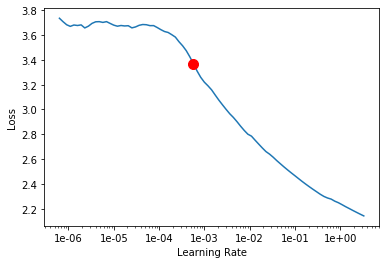

In [18]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [19]:
learner.fit_one_cycle(63, max_lr=learner.recorder.min_grad_lr) # It was best after 63 epochs

epoch,train_loss,valid_loss,time
0,3.629193,3.380390,00:16
1,3.542353,3.222339,00:16
2,3.375453,2.661295,00:16
3,3.067780,1.637514,00:16
4,2.678396,1.838518,00:16
5,2.361804,1.685454,00:16
6,2.163586,1.607173,00:16
7,2.008552,2.148596,00:16
8,1.895013,2.487809,00:16
9,1.811264,2.098696,00:16


In [15]:
learner.save(MODEL_NAME+"_T=0.358")

In [16]:
x, (y, _) = databunch.one_batch()
x_device = x.to(device=DEVICE)
y_pred = model(x_device).detach().cpu().numpy()

In [1]:
r = range(min(5, DIMENSIONS_PREDICTION_OUT), min(DIMENSIONS_PREDICTION_OUT+1, 50)) #Range can't contain values larger than PRED_OUT_DIM

for index in [0, BS//2, BS-1]:
    actual = pop.convert_idx_to_base_sequence(y[index], ALPHABET_VAL)
    prediction = y_pred[index]
    for pred, beam, error in e.get_stats(prediction, actual, ALPHABET_STR, r):
        print(pred, beam, error.error)
    print('')

NameError: name 'DIMENSIONS_PREDICTION_OUT' is not defined

In [23]:
# Run assemble only if data is not fetched from featherfile
# TODO: Assembled should not be on a batch, but instead on a complete signal
if STRIDE != WINDOW_SIZE:
    decoded = pop.decode(y_pred, ALPHABET_STR, beam_size=15)
    assembled = pop.assemble(decoded, WINDOW_SIZE, STRIDE, ALPHABET)
    print('Assembled:', assembled)